In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import yfinance as yf

from arch.compat.numba import jit

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
plt.style.use("bmh")
plt.rcParams['font.family'] = 'DejaVu Sans'

from enum import Enum
import math

In [2]:
# FIXME: ADD alpha treshold?
class BetaType(Enum):
    NO = 1
    RAW = 2
    RETURNS = 3
    FILTERED = 4

In [3]:
DATE_FROM = '2010-01-01'
DATE_TO = '2018-12-31'
TEST_DATE_FROM = '2018-01-01'
TEST_DATE_TO = '2019-12-31'
REAL_DATE_FROM = '2020-01-01'
REAL_DATE_TO = '2020-09-22'
tickers = ['ARE', 'CTL', 'ALD', 'AAP', 'MMM',
           'ABMD', 'TSLA', 'APD', 'ATO', 'AMZN']

INITIAL_CASH = 500000
FEE = 0.001
MAX_POSITION_PER_EQUITY = max(1. / len(tickers), 0.2)
MAX_POSITION_PER_EQUITY_PER_TRADE = max(1. / len(tickers), 0.05)
MAX_DRAWDOWN_PER_DAY = 0.005
MAX_DRAWDOWN_PER_WEEK = 0.02

In [4]:
BETA_TYPE = BetaType.FILTERED
BETA_LAG = 30
GARCH_LAG = 190
CORRELATION_MATRIX_LAG = 30
GARCH_REFIT_DELAY_DAYS = 30

In [5]:
MEAN_MODEL = "Constant"
VOL_MODEL = "Garch"
DISTRIBUTION_ = "Normal"

In [6]:
p_ = 2
o_ = 0
q_ = 2

In [7]:

def _find_best_model_params(TS: pd.Series):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(1, 5) # [1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(method='mle', trend='nc')
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order

In [8]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [9]:
def raw_adj_close_prices(ticker: str, date_from: str, date_to: str):
    prices = yf.download(ticker, date_from, date_to).dropna()
    prices.index = prices.index.to_period(freq='d')
    return prices['Adj Close']

In [10]:
def raw_adj_close_log_returns(prices: pd.Series):
    return np.log(prices).diff().fillna(0)

In [11]:
def beta(market: pd.Series, single_stock: pd.Series, lag: int = 252):
    return market.cov(single_stock, lag) / market.var(ddof=lag)

In [12]:
@jit
def arch_filtered_series(returns: pd.Series,
                         dist: str = 'Normal',
                         mean: str = 'HARX',
                         vol: str = 'Garch',
                         lag: int = 200,
                         p: int = 1,
                         o: int = 0,
                         q: int = 1,
                         forecast_horizon: int = 30):
    scaling_const = 10.0 / returns.std()

    model = arch_model(scaling_const * returns,
                       mean=mean,
                       lags=lag,
                       vol=vol, 
                       p=p, o=o, q=q,
                       dist=dist)

    res = model.fit(update_freq=0, disp='off')
    stand_residuals = res.resid / res.conditional_volatility
    forecast = res.forecast(horizon=forecast_horizon)
    means = pd.Series(forecast.mean.tail(1).to_numpy()[0]) / scaling_const
    varis = pd.Series(forecast.variance.tail(1).to_numpy()[0]) / (scaling_const ** 2)
    return stand_residuals, means, varis

In [13]:
@jit
def get_filtered_data(nmkt_rets_df):
    net_market_returns_f = {}
    means = {}
    varis = {}
    for ticker, net_rets in nmkt_rets_df.iteritems():
        fltr_res, fcst_means, fcst_vars = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                                              mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_,
                                                              p=p_, o=o_, q=q_)
        net_market_returns_f[ticker] = fltr_res[GARCH_LAG:]
        means[ticker] = fcst_means
        varis[ticker] = fcst_vars

    nmkt_retsf_df = pd.DataFrame(net_market_returns_f, columns=tickers)
    means_df = pd.DataFrame(means, columns=tickers)
    vars_df = pd.DataFrame(varis, columns=tickers)
    return (nmkt_retsf_df, means_df, vars_df)

In [14]:
def remove_row_and_column(matrix: np.array, index: int):
    tmp = np.delete(matrix, (index), axis=0)
    return np.delete(tmp, (index), axis=1)

In [15]:
def calc_alphas(real_returns: pd.DataFrame, corr_matrix: pd.DataFrame, means: pd.DataFrame, varis: pd.DataFrame):
    alphas = {}
    for i in range(0, len(tickers)):
        ticker = tickers[i]
        r_j_j = remove_row_and_column(corr_matrix.to_numpy(), i)
        inv_r_j_j = np.linalg.inv(r_j_j)
        mu_j = np.delete(means.to_numpy(), i)
        sigma_j = np.delete(varis.to_numpy(), i)
        rets = np.delete(real_returns.to_numpy(), i)
        v = (rets - mu_j) / sigma_j
        corr_v = np.delete(corr_matrix[ticker].to_numpy(), i)
        mu = means[ticker] + varis[ticker] * corr_v.dot(inv_r_j_j).dot(v)
        alphas[ticker] = alpha(mu, real_returns[ticker])
    return pd.DataFrame(alphas, columns=tickers, index=[0])

In [16]:
def alpha(mu, real_return):
    return 2 * mu - real_return



In [17]:
spy_p = raw_adj_close_prices('SPY', DATE_FROM, DATE_TO)

raw_prices = {}
for ticker in tickers:
    raw_prices[ticker] = raw_adj_close_prices(ticker, DATE_FROM, DATE_TO)
rp_df = pd.DataFrame(raw_prices, columns=tickers)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [18]:
rp_df.tail(1)

,ARE,CTL,ALD,AAP,MMM,ABMD,TSLA,APD,ATO,AMZN
Date,,,,,,,,,,
2018-12-28,109.393845,13.134362,43.333111,154.000809,178.148697,318.170013,66.774002,154.316376,88.341759,1478.02002


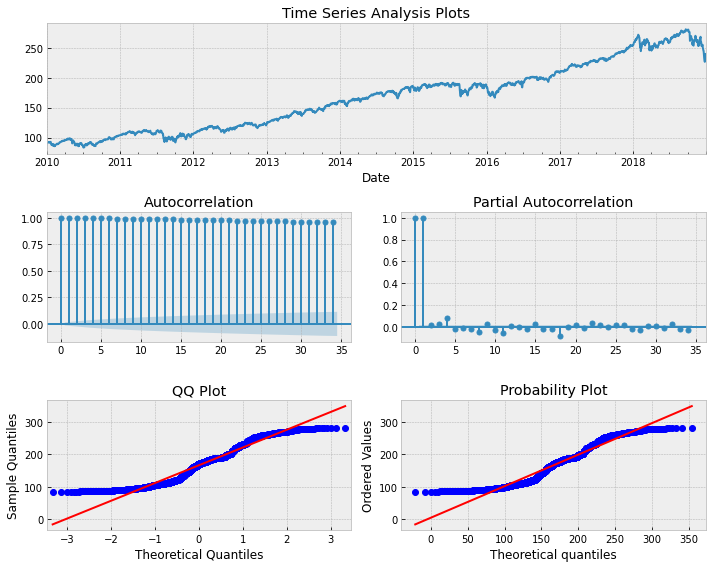

In [19]:
tsplot(spy_p)

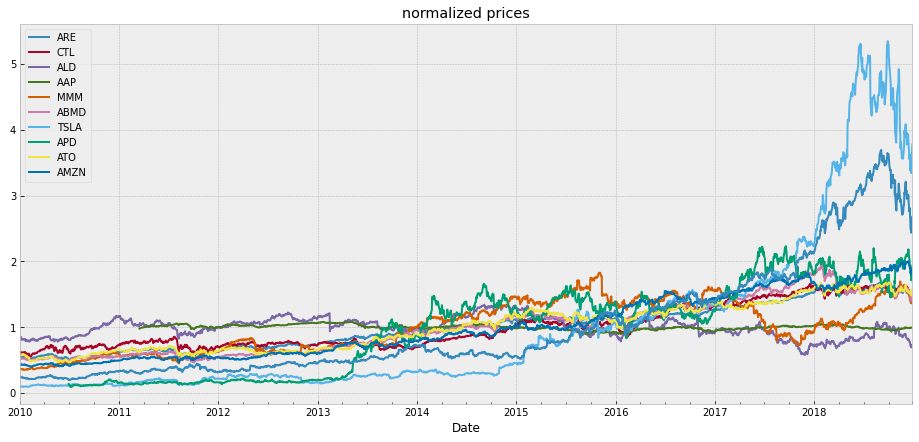

In [20]:
plt.figure(figsize=(16,7))
(spy_p / spy_p.mean()).plot()
for _, data in rp_df.iteritems():
    (data / data.mean()).plot()
plt.title("normalized prices")
plt.legend(tickers)
plt.show()

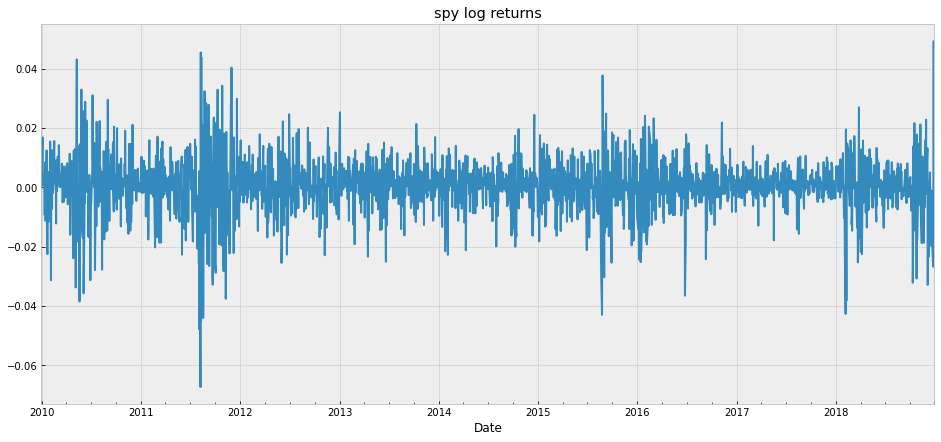

In [21]:
spy = raw_adj_close_log_returns(spy_p)
plt.figure(figsize=(16,7))
spy.plot()
plt.title("spy log returns")
plt.show()

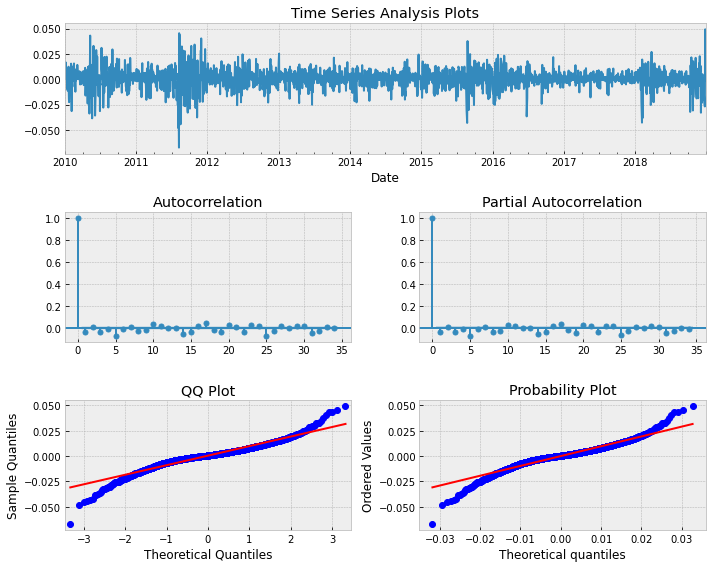

In [22]:
tsplot(spy)

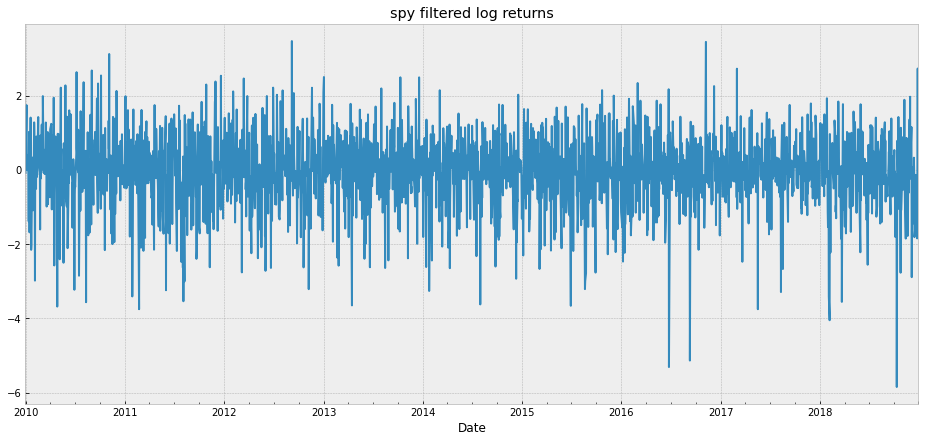

In [23]:
spyf, spy_means, spy_vars = arch_filtered_series(spy, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                                mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_,
                                                p=p_, o=o_, q=q_)
plt.figure(figsize=(16,7))
spyf.plot()
plt.title("spy filtered log returns")
plt.show()

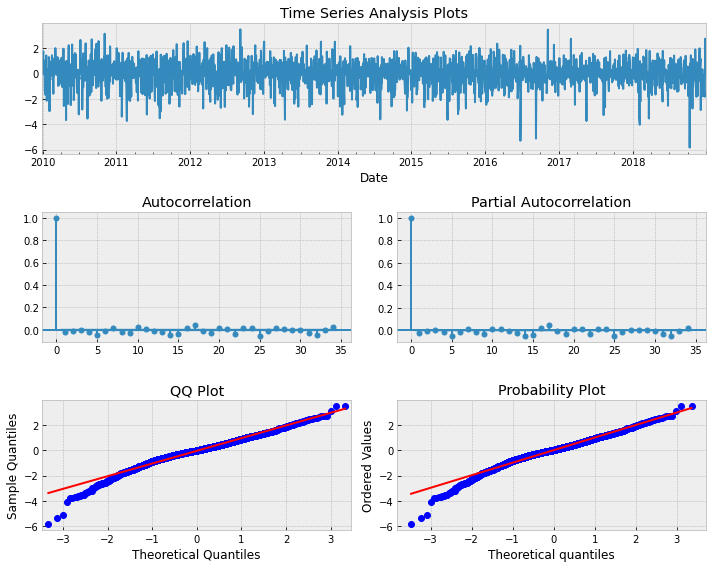

In [24]:
tsplot(spyf)

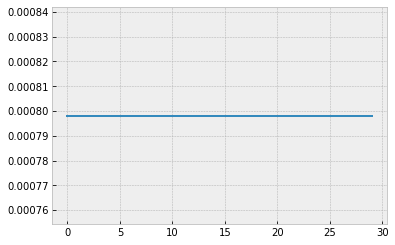

In [25]:
spy_means.plot()
plt.show()

In [26]:
res = spy_p.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spy.values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
res = spyf.dropna().values
result = adfuller(res)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.663833
p-value: 0.855897
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -10.447392
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567
ADF Statistic: -48.521715
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


In [27]:
mkt_returns = {}
for ticker, data in rp_df.iteritems():
    mkt_returns[ticker] = raw_adj_close_log_returns(data)

In [28]:
# %%time
# aic, params = _find_best_model_params(spy)

In [29]:
# for ticker in tickers:
#    aic, params = _find_best_model_params(mkt_returns[ticker])

In [30]:
%%time
betas = {}
if BETA_TYPE == BetaType.NO:
    for ticker in tickers:
        betas[ticker] = 0
elif BETA_TYPE == BetaType.RAW:
    for ticker, data in raw_prices.items():
        betas[ticker] = beta(spy_p, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.RETURNS:
    for ticker, data in mkt_returns.items():
        betas[ticker] = beta(spy, data, lag=BETA_LAG)
elif BETA_TYPE == BetaType.FILTERED:
    filtered_returns = {}
    for ticker, net_rets in mkt_returns.items():
        fltr_res, _, _ = arch_filtered_series(net_rets, lag=GARCH_LAG, forecast_horizon=GARCH_REFIT_DELAY_DAYS,
                                              mean=MEAN_MODEL, vol=VOL_MODEL, dist=DISTRIBUTION_, 
                                              p=p_, o=o_, q=q_)
        filtered_returns[ticker] = fltr_res[GARCH_LAG:]
    for ticker, data in filtered_returns.items():
        betas[ticker] = beta(spyf, data, lag=BETA_LAG)
betas

C:\Users\krems\anaconda3\envs\cmf_case_1_week\lib\site-packages\arch\univariate\base.py:707: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Wall time: 922 ms


{'ARE': 0.4849479822506367,
 'CTL': 0.3887797365776445,
 'ALD': 0.3059508479166953,
 'AAP': 0.37511966524434454,
 'MMM': 0.6903508722271874,
 'ABMD': 0.3877858069259505,
 'TSLA': 0.36094261168604985,
 'APD': 0.66476738717921,
 'ATO': 0.44549667753234107,
 'AMZN': 0.5052697330469971}

In [31]:
net_market_returns = {}
for ticker, data in mkt_returns.items():
    net_market_returns[ticker] = data - spy * betas[ticker]
    
nmkt_rets_df = pd.DataFrame(net_market_returns, columns=tickers)
nmkt_rets_df



,ARE,CTL,ALD,AAP,MMM,ABMD,TSLA,APD,ATO,AMZN
Date,,,,,,,,,,
2009-12-31,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2010-01-04,-0.019733,0.005813,-0.005145,-0.008782,-0.007385,-0.005377,-0.006070,0.014397,-0.003419,-0.013117
2010-01-05,-0.011881,0.000607,-0.000809,-0.006953,-0.008108,-0.025346,-0.000954,-0.010089,-0.011734,0.004547
2010-01-06,-0.005604,-0.040279,-0.000215,0.008418,0.013596,-0.015631,-0.000254,-0.008747,0.000028,-0.018637
2010-01-07,0.007187,-0.011322,-0.001289,-0.001827,-0.002192,-0.001634,-0.001521,-0.008564,-0.011505,-0.019288
...,...,...,...,...,...,...,...,...,...,...
2018-12-21,-0.007833,-0.029493,0.002664,0.000593,-0.005271,0.028949,0.021296,0.017960,0.002470,-0.048310
2018-12-24,-0.031876,-0.015423,0.010034,-0.006537,-0.009829,-0.021857,-0.069640,-0.017014,-0.043910,-0.011083
2018-12-26,0.009010,0.033163,-0.012096,0.021720,0.007855,0.070527,0.081086,0.013135,-0.013154,0.065349


In [32]:
%%time
today = 2 * GARCH_LAG + 1
nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[(today - 2 * GARCH_LAG - 1): today])#fixme check

Wall time: 683 ms


In [33]:
corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)

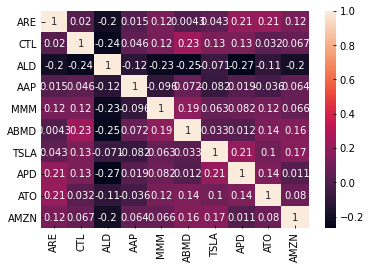

In [34]:
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [35]:
def trade(alphas, positions, prices, i):
    new_positions = pd.DataFrame({}, columns=tickers, index=[0])
    cash = positions.iloc[0]['CASH']
    if cash < 0:
        print("Negative cash! Bankrupt! ", cash, " @ ", i)
        print(alphas)
        print('=======================================================')
        print(positions)
        print('=======================================================')
        print(prices)
    pv_ = cash
    for ticker in tickers:
        pv_ = pv_ + positions.iloc[0][ticker] * prices[ticker]
    expected_positions = alphas.iloc[0] * pv_
    max_pos = pv_ * MAX_POSITION_PER_EQUITY
    max_trade = pv_ * MAX_POSITION_PER_EQUITY_PER_TRADE
    for ticker in tickers:
        expected_positions[ticker] = min(expected_positions[ticker], max_pos)
    for ticker in tickers:
        amount_to_buy = expected_positions[ticker] - positions.iloc[0][ticker] * prices[ticker]
        if abs(amount_to_buy) > max_trade:
            amount_to_buy = math.copysign(max_trade, amount_to_buy)
        cash = cash - amount_to_buy - abs(amount_to_buy) * FEE
        new_positions[ticker] = positions.iloc[0][ticker] + amount_to_buy / prices[ticker]
    new_positions['CASH'] = cash    
    return pv_, new_positions
    

In [36]:
%%time
init_positions = {}
for ticker in tickers:
    init_positions[ticker] = 0
init_positions['CASH'] = INITIAL_CASH
positions = pd.DataFrame(init_positions, index=[0])

pv_series = [INITIAL_CASH]
last_refit_date = GARCH_LAG * 2 + 1
while last_refit_date < len(rp_df):
    nmkt_retsf_df, means_df, vars_df = get_filtered_data(nmkt_rets_df[: last_refit_date])#fixme check
    corr_matrix = nmkt_retsf_df.corr(min_periods=CORRELATION_MATRIX_LAG)
    for offset in range(0, GARCH_REFIT_DELAY_DAYS):
        today = min(last_refit_date + offset + 1, len(nmkt_rets_df) - 1)
        alphas = calc_alphas(nmkt_rets_df.iloc[today], corr_matrix, means_df.iloc[offset], vars_df.iloc[offset])
        alphas_array = alphas.to_numpy()
        # alpha_norma = max(max(alphas_array[0]), -min(alphas_array[0]))
        alpha_norma = alphas_array[0].sum()
        normalized_alphas = alphas / alpha_norma # / 100 * MAX_POSITION_PER_EQUITY
        pv, new_positions = trade(normalized_alphas, positions.tail(1), rp_df.iloc[today], today)
        pv_series.append(pv)
        positions = positions.append(new_positions, ignore_index=True)
    last_refit_date = last_refit_date + GARCH_REFIT_DELAY_DAYS

Negative cash! Bankrupt!  -89319.12732128156  @  1105
        ARE       CTL       ALD       AAP       MMM      ABMD      TSLA  \
0 -0.011161  0.024213  0.008304  0.131359  0.007515  0.422689  0.323574   

       APD      ATO      AMZN  
0  0.02475  0.01487  0.053885  
             ARE         CTL          ALD         AAP        MMM         ABMD  \
723  1077.298598  2972.11516  1482.632685  974.107853  525.84219  5478.866409   

            TSLA         APD          ATO        AMZN          CASH  
723  1480.273849  570.150659 -1093.748579  384.532281 -89319.127321  
ARE      61.981812
CTL      21.188530
ALD      44.517784
AAP     121.091347
MMM     118.575356
ABMD     21.100000
TSLA     41.459999
APD      92.811974
ATO      43.412750
AMZN    312.239990
Name: 2014-05-23, dtype: float64
Negative cash! Bankrupt!  -5077.344237878709  @  1506
        ARE       CTL       ALD       AAP       MMM      ABMD     TSLA  \
0  0.003662  0.096839  0.044941  0.146016  0.007954  0.300732  0.16745   

  

In [37]:
positions.head()


,ARE,CTL,ALD,AAP,MMM,ABMD,TSLA,APD,ATO,AMZN,CASH
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,500000.000000
1,724.503947,270.170544,180.552383,610.023246,426.013299,2995.805776,-8677.542394,633.792050,215.813159,229.063589,274754.712687
2,465.436677,-450.869908,98.144633,649.158120,354.302420,6033.269444,65.209893,392.197423,19.255824,279.335161,222168.679952
3,18.663576,1274.789467,153.233112,999.689559,481.946658,6095.293830,-4063.444185,692.624509,-149.099110,468.336023,151968.276675
4,173.600708,-246.403678,87.359032,243.707105,216.826297,5980.966133,2281.240669,365.059803,-35.589282,322.077832,250979.292037


In [38]:
positions.tail()

,ARE,CTL,ALD,AAP,MMM,ABMD,TSLA,APD,ATO,AMZN,CASH
1886,89.820956,2449.307457,-42.337192,417.562783,416.752555,355.908625,-2472.846206,-377.217030,-251.038716,-33.479449,569167.767938
1887,88.190207,2366.659699,-41.461382,361.590935,402.031842,355.862825,-2901.431281,-364.464035,-242.934619,-32.245730,605715.763144
1888,85.076056,2256.845462,-38.115172,380.337057,383.265950,355.834108,-2791.650395,-348.987793,-233.667612,-30.999000,595418.458383
1889,83.540688,2185.751684,-37.301112,334.299532,370.448045,355.821193,-2687.039071,-337.871790,-226.575233,-29.928547,594931.506202
1890,80.990628,2093.916506,-34.534917,348.975944,354.767499,355.807726,-2594.621235,-324.917216,-218.811137,-28.881743,586414.001738


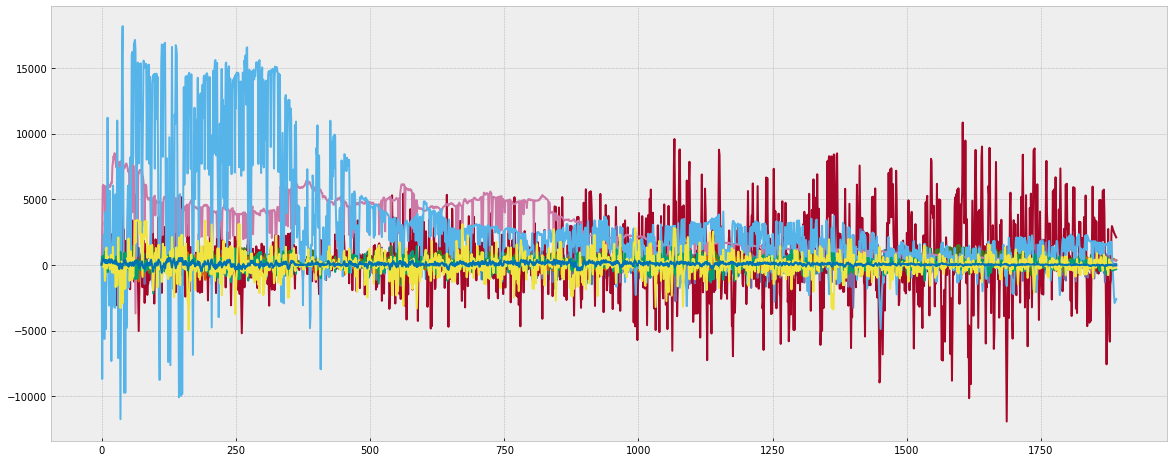

In [39]:
plt.figure(figsize=(20, 8))
for ticker in tickers:
    positions[ticker].plot()

<AxesSubplot:>

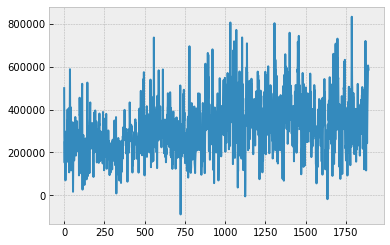

In [40]:
positions['CASH'].plot()

<AxesSubplot:xlabel='Date'>

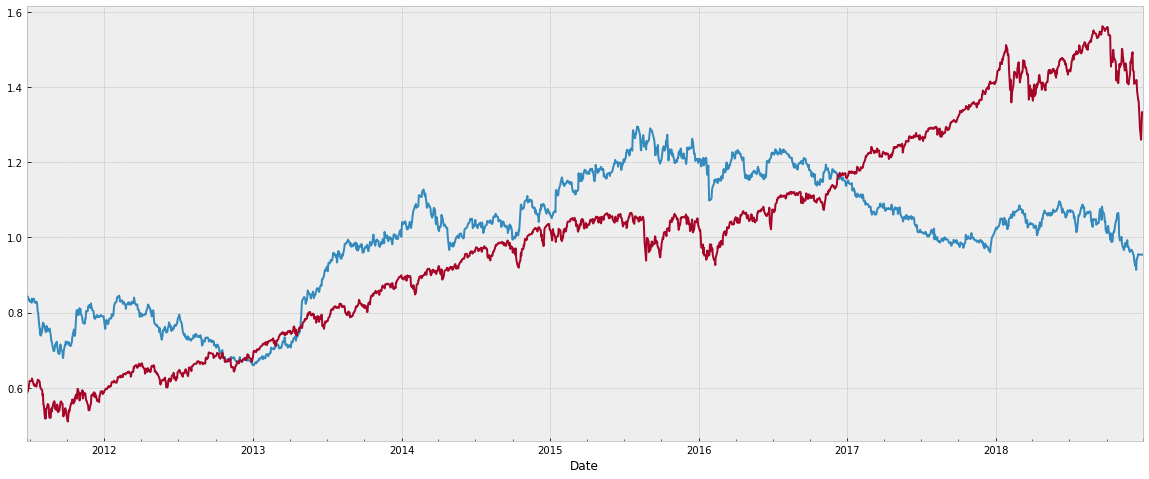

In [41]:
pv_s = pd.Series(pv_series)
pv_s.index = spy_p.index[-len(positions):]
plt.figure(figsize=(20, 8))
(pv_s / pv_s.mean()).plot()
(spy_p[-len(positions):] / spy_p[-len(positions):].mean()).plot()
# (rp_df['ALD'][-len(positions):] / rp_df['ALD'][-len(positions):].mean()).plot()
# (rp_df['MMM'][-len(positions):] / rp_df['MMM'][-len(positions):].mean()).plot()

<AxesSubplot:xlabel='Date'>

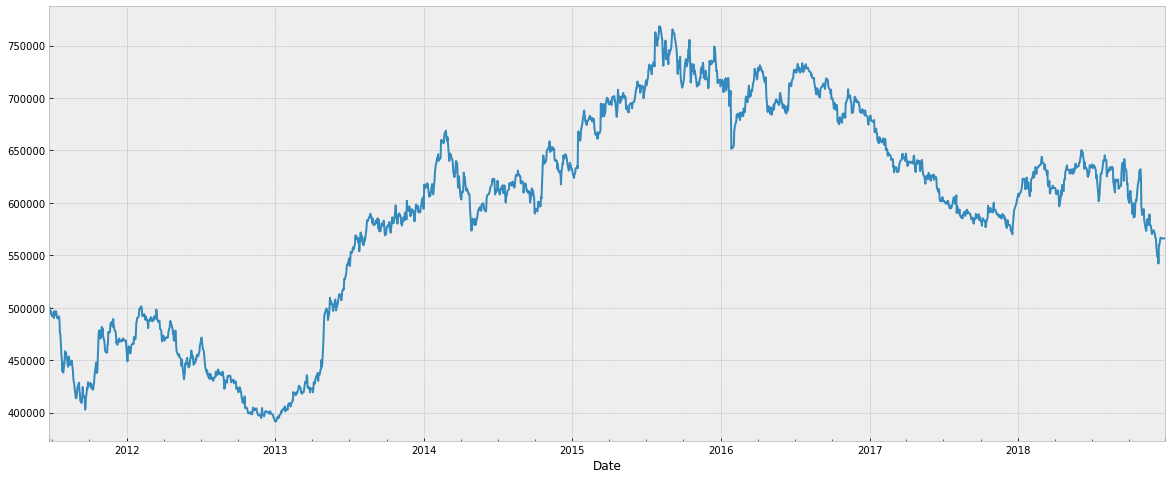

In [42]:
plt.figure(figsize=(20, 8))
pv_s.plot()

In [43]:
total_return = (pv_s[-1:] - INITIAL_CASH) / INITIAL_CASH
total_return

Date
2018-12-28    0.132073
Freq: D, dtype: float64

<AxesSubplot:xlabel='Date'>

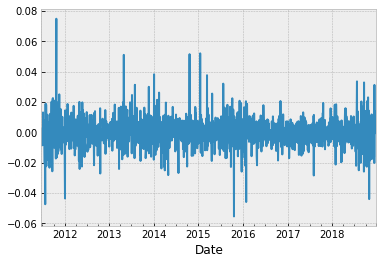

In [44]:
pnl = raw_adj_close_log_returns(pv_s)
pnl.plot()

In [45]:
pnl_abs = pv_s.diff()

In [46]:
max_dd_daily = pnl_abs.min() / INITIAL_CASH
max_dd_daily

-0.08134343454124918

In [47]:
max_dd_weekly = 0
for i in range(7, len(pnl_abs)):
    dd = pnl_abs[i - 7: i].max() - pnl_abs[i - 7: i].min()
    if dd > max_dd_weekly:
        max_dd_weekly = dd
max_dd_weekly / INITIAL_CASH

0.10353071659615054

In [48]:
beta(spy[-len(pnl):], pnl)

-0.010512178391929368

In [49]:
sharp = pnl.mean() / pnl.std()
sharp

0.007356031721872682

In [50]:

def var_graph(ret: pd.Series):
    VaR_HS_01 = ret.quantile(0.01)
    VaR_HS_05 = ret.quantile(0.05)
    VaR_HS_10 = ret.quantile(0.10)

    fig = plt.figure(figsize=(16, 5))

    sns.distplot(ret, hist=True, kde=False,
             bins=60,
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

    plt.axvline(x=VaR_HS_01, linewidth=4, color="r")
    plt.axvline(x=VaR_HS_05, linewidth=4, color="y")
    plt.axvline(x=VaR_HS_10, linewidth=4, color="g")

    plt.title("Histogram of daily returns", weight="bold")

    plt.legend(['VaR for alpha=1%: {:.2f}'.format(VaR_HS_01),
            'VaR for alpha=5%: {:.2f}'.format(VaR_HS_05),
            'VaR for alpha=10%: {:.2f}'.format(VaR_HS_10)], fontsize=12)

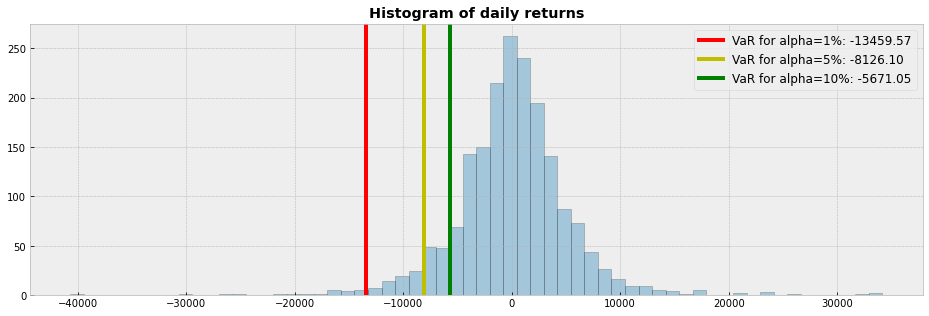

In [51]:
var_graph(pnl_abs)


In [52]:
def calculate_VaR_garch(returns, alpha):
    scaling_const = 10.0 / returns.std()
    dist = 'skewstudent'
    am = arch_model(scaling_const * returns,
                    mean='HARX', lags=1,
                    vol='Garch', p=1, o=1, q=1,
                    dist=dist) # dist = Normal, t, skewstudent, ged

    res = am.fit(update_freq=0, disp='off')

    forecasts = res.forecast(horizon=1)

    cond_mean = float(forecasts.mean.iloc[-1])
    cond_var = float(forecasts.variance.iloc[-1])

    q = 1
    if dist == 'Normal':
        q = am.distribution.ppf(alpha)
    elif dist == 't' or dist == 'ged':
        q = am.distribution.ppf(alpha, res.params[-1:])
    elif dist == 'skewstudent':
        q = am.distribution.ppf(alpha, res.params[-2:])

    VaR_garch_forecast = (cond_mean + np.sqrt(cond_var) * q) / scaling_const
    return VaR_garch_forecast


In [53]:
def calc_VaR(r, VaR_fun, L_history=252, level=0.05):
    VaR = np.full(r.size, np.nan)

    for i in range(L_history, len(r)):
        history = r[i - L_history: i]
        VaR[i] = VaR_fun(history, level)

    return pd.Series(data=VaR, index=r.index, name=VaR_fun.__name__)

<AxesSubplot:xlabel='Date'>

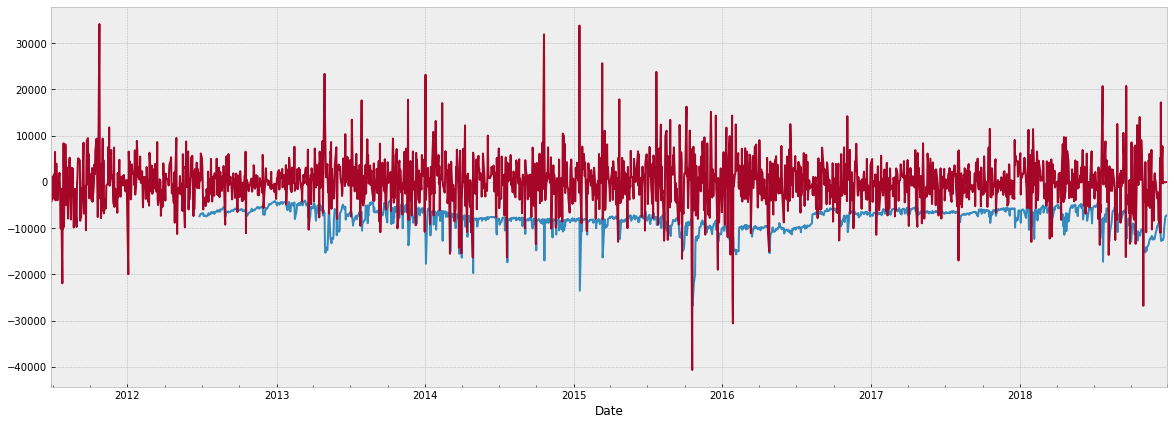

In [56]:
%%time
var_5 = calc_VaR(pnl_abs.dropna(), calculate_VaR_garch, level=0.05)
plt.figure(figsize=(20, 7))
var_5.plot()
pnl_abs.dropna().plot()


In [57]:
loss_var = pnl_abs.quantile(0.05)
win_var = (-pnl_abs).quantile(0.05)
rachev = win_var / loss_var
rachev



0.9309402176279594